In [2]:
! pip install --upgrade tqdm spacy kaggle -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.3.4 requires botocore<1.24.22,>=1.24.21, but you have botocore 1.27.27 which is incompatible.


In [9]:
# ! python -m spacy download en_core_web_sm

In [3]:
%matplotlib inline

In [46]:
import pandas as pd
import numpy as np
from difflib import SequenceMatcher
from tqdm.auto import tqdm
import kaggle
from nltk.tokenize import word_tokenize
import spacy
import re
from itertools import combinations
import scipy

In [5]:
tqdm.pandas()

In [10]:
nlp = spacy.load("en_core_web_sm")

# Nutrition

In [2]:
# get nutrition data
# get recommended food
# (get body composition)
# find closest food to recommended (/ to body composition)
# find minimal foods (pair, 3, 4... 10) closest to recommended (/ to body composition)



In [3]:
# ! curl https://www.myfooddata.com/spreadsheets/MyFoodData-Nutrition-Facts-SpreadSheet-Release-1-4.xlsx -o data/nutrition.xlsx

In [16]:
df = pd.read_excel('data/nutrition.xlsx', skiprows=3, index_col=0)

In [10]:
dfs = pd.read_html('https://en.wikipedia.org/wiki/Dietary_Reference_Intake')

In [11]:
vitamins = dfs[0]
minerals = dfs[1]
macro = dfs[3]
vitamins.columns = vitamins.columns.droplevel()
vitamins = vitamins[['Nutrient', 'Males', 'Unit']]
minerals.columns = minerals.columns.droplevel()
minerals = minerals[['Nutrient', 'Males', 'Unit']]
macro = macro[macro['Amount (males)'].apply(lambda x: 'g/day' in x)]
macro = pd.concat([macro,macro['Amount (males)'].str.split(expand=True)], axis=1)
macro = macro[['Substance', 0,1]]
macro = macro.rename({'Substance':'Nutrient', 0: 'Males', 1: 'Unit'}, axis=1)
macro['Unit'] = 'g'


In [12]:
intake = pd.concat([macro, vitamins, minerals])
intake['Nutrient (unit)'] = intake.apply(lambda x: f"{x['Nutrient']} ({x['Unit']})", axis=1)

In [7]:
# combine tables

In [8]:
# for each entry in intake, find cloasest in df columns

In [17]:
def find_closest_name(x):
    r = 0 #.75
    closest = None
    for col in df.columns:
        r_ = SequenceMatcher(None, x, col).ratio()
        if r_>r:
            closest =  col
            r = r_
    return closest

In [23]:
intake['closest'] = intake['Nutrient (unit)'].apply(find_closest_name)
intake['dist'] = intake.apply(lambda x: SequenceMatcher(None, x['Nutrient (unit)'], x['closest']).ratio() if x['closest'] else None, axis=1)
intake = intake[intake['dist']>0.75]
intake = intake.sort_values('dist').drop_duplicates(subset='closest',  keep='last')
# normalize (by size / by calories)
intake = intake.set_index('closest')[['Males']].T
intake = intake.apply(pd.to_numeric)

In [24]:
def get_size(x):
#     print(x)
    return x.pow(2).sum()**0.5

In [25]:
norm_intake = intake/get_size(intake.iloc[0])

In [26]:
combined = pd.concat([intake, df.set_index('name')[intake.columns]])

In [27]:
# normalize by size - root sum squares

In [28]:
combined = combined.apply(pd.to_numeric)

In [29]:
combined.to_csv('data/nutrition.csv')

In [11]:
combined = pd.read_csv('data/nutrition.csv', index_col=0)

# filter unpopular foods

In [49]:
# ! echo '{"username":"jvalansi","key":"6e067d49e0261887197d3b6d71e37d66"}' > /root/.kaggle/kaggle.json

In [51]:
# ! chmod 600 /root/.kaggle/kaggle.json

In [124]:
kaggle.api.dataset_download_files('rtatman/english-word-frequency', path='data/english-word-frequency', unzip=True)

In [125]:
unigrams = pd.read_csv('data/english-word-frequency/unigram_freq.csv', index_col=0)

In [126]:
unigrams_dict = unigrams['count'].to_dict()

In [127]:
total = sum(unigrams['count'])

In [130]:
def get_ngram_prob(x):
    probs = []
    tokens = nlp(x.lower())
    for token in tokens:
#         print(token)
        if re.match('\w+', token.text) is None:
            continue
        if token.text in unigrams_dict:
            probs+=[np.log(unigrams_dict[token.text]/total)]
#             print(np.log(unigrams_dict[token.text]/total))
        else:
            probs+=[np.log(1/total)]
    return min(probs) # sum(probs)/len(probs)

In [131]:
s = combined.progress_apply(lambda x: get_ngram_prob(x.name), axis=1)

  0%|          | 0/14165 [00:00<?, ?it/s]

In [132]:
s = s.sort_values(ascending=False)

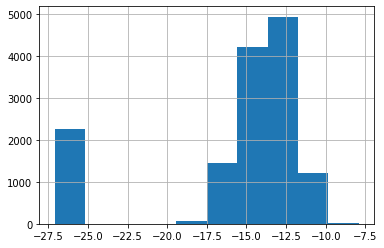

In [133]:
s.hist()

In [272]:
list(s.sort_values(ascending=False).index).index(intake_closest.index[6])

1267

In [136]:
s[:1000].index

Index(['Well Water', 'White Wine', 'Table Wine', 'Red Wine', 'Fish Stock',
       'White Russian', 'Black Russian', 'Seven And Seven', 'High Ball',
       'Palm Oil',
       ...
       'Shark Cooked Ns As To Cooking Method',
       'Sea Bass Cooked Ns As To Cooking Method', 'Cooked Small White Beans',
       'Beans String Cooked Ns As To Form Ns As To Color Made With Oil',
       'White Beans Dry Cooked Fat Added In Cooking Ns As To Type Of Fat',
       'Beans String Yellow Cooked Ns As To Form Ns As To Fat Added In Cooking',
       'Beans String Yellow Cooked From Frozen Fat Not Added In Cooking',
       'Beans String Yellow Cooked From Fresh Fat Not Added In Cooking',
       'Green Or Yellow Split Peas Dry Cooked Fat Not Added In Cooking',
       'White Beans Dry Cooked Made With Oil'],
      dtype='object', length=1000)

In [137]:
# intake_dist.loc[s[:1000].index].sort_values(ascending=False)[1:10]

# normalize

In [ ]:
# look at percent of daily intake

In [157]:
# combined = combined.loc[['Males']+list(s[:1000].index)]

In [12]:
combined = combined[~combined.duplicated()]

In [13]:
percentage = combined/combined.iloc[0]

In [14]:
percentage = percentage.fillna(0)

In [ ]:
# look for the most evenly distributed 
# - normalize by size
# - look for the minimum distance

In [16]:
sizes = np.linalg.norm(percentage,axis=1)

In [17]:
percentage = percentage[sizes>0]
sizes = sizes[sizes>0]

In [95]:
inflated = ((percentage*sizes[0]).T/sizes).T

In [19]:
normalized = (percentage.T/sizes).T

In [112]:
# dist_from_mean = (((inflated.T-inflated.mean(axis=1)).T)**2).sum(axis=1)

In [35]:
dist_from_intake = pd.Series(np.linalg.norm(normalized-normalized.loc['Males'],axis=1), index=normalized.index)

In [36]:
i=0

In [37]:
dist_from_intake.sort_values()[20*i:20*(i+1)]

Males                                                                                             0.000000
Nestle Boost Plus Nutritional Drink Ready-To-Drink                                                0.594011
Nutritional Drink Or Shake Ready-To-Drink (Carnation Instant Breakfast)                           0.613065
Abbott Ensure Plus Ready-To-Drink                                                                 0.613897
Peas From Fresh Creamed                                                                           0.616352
Babyfood Dinner Vegetables Chicken Strained                                                       0.623661
Nutritional Supplement For People With Diabetes Liquid                                            0.624231
Abbott Ensure Nutritional Shake Ready-To-Drink                                                    0.627972
Babyfood Carrots And Beef Strained                                                                0.628442
Babyfood Dinner Vegetables And Turkey

In [38]:
normalized.loc['Nestle Boost Plus Nutritional Drink Ready-To-Drink']

Copper, Cu (mg)               0.000366
Selenium, Se (mcg)            0.209207
Zinc, Zn (mg)                 0.270096
Iron, Fe (mg)                 0.270096
Fluoride, F (mcg)             0.000000
Vitamin D (mcg)               0.197498
Vitamin K (mcg)               0.176031
Potassium, K (mg)             0.069705
Molybdenum (mcg)              0.000000
Biotin (B7) (mcg)             0.000000
Folate (B9) (mcg)             0.163151
Phosphorus, P (mg)            0.157998
Chlorine (mg)                 0.000000
Carbohydrate (g)              0.228411
Protein (g)                   0.164991
Manganese (mg)                0.200858
Magnesium (mg)                0.155382
Fiber (g)                     0.054233
Vitamin B6 (mg)               0.271749
Pantothenic acid (B5) (mg)    0.330079
Calcium (mg)                  0.178343
Choline (mg)                  0.065885
Sodium (mg)                   0.088159
Niacin (B3) (mg)              0.164975
Vitamin C (mg)                0.440793
Thiamin (B1) (mg)        

# find combinations that work

In [ ]:
# for each pair find 'a' such that a*v0 + (1-a)*v1 is closest to uniform

In [195]:
v1 = inflated.iloc[1]

In [196]:
v2 = inflated.iloc[2]

In [199]:
a = 0.1

In [200]:
v = a*v1+(1-a)*v2

In [201]:
v.mean()

0.16040499883361917

In [202]:
intake = inflated.loc['Males']

In [203]:
def get_dist_from_intake(v):
    return ((v-intake)**2).sum()

In [204]:
def get_min_dist(v1,v2):
    return min([get_dist_from_intake(a*v1+(1-a)*v2) for a in np.arange(0,1.1,0.1)])

In [205]:
get_min_dist(v1,v2)

27.583002488130358

In [210]:
len(inflated)

903

In [23]:
# combs = []
# for i,j in tqdm(combinations(range(len(inflated)),2),total=len(inflated)**2):
#     pass
#     v1 = inflated.iloc[i]
#     v2 = inflated.iloc[j]
#     combs.append((get_min_dist(v1,v2),i,j))

In [105]:
N = len(v)

In [211]:
# F
# (a*v1[0]+(1-a)*v2[0]-sum(a*v1+(1-a)*v2)/N)**2 + ... + (a*v1[N-1]+(1-a)*v2[N-1]-sum(a*v1+(1-a)*v2)/N)**2
# dF / da
# 2*(a*v1[0]+(1-a)*v2[0]-sum(a*v1+(1-a)*v2)/N)*(v1[0]-v2[0]-sum(v1-v2)/N)+ ... + 2*(a*v1[N-1]+(1-a)*v2[N-1]-sum(a*v1+(1-a)*v2)/N)*(v1[N-1]-v2[N-1]-sum(v1-v2)/N)=0
# sum[ 2*(a*v1[i]**2+(1-a)*v2[i]*v1[i]+m*v1[0]-a*v1[i]*v2[i]-(1-a)*v2[i]**2-m*v2[i]-a*v1[i]*m_+(1-a)*v2[i]*m_

In [23]:
# split space to 2 from the target point
# for each of the points on one side, find the best point on the other size
# I can split it up on each of the axis
# 

In [ ]:
# I can reduce the target point from the option point and look for the closest point in the rest of the points

In [124]:
reverted = normalized.loc['Males'] - normalized

In [125]:
sizes = np.linalg.norm(reverted,axis=1)

In [126]:
reverted = (reverted.T/sizes).T

In [127]:
def get_closest_vec(vec):
    closest = reverted.dot(vec).sort_values(ascending=False)
    return closest.iloc[0], closest.index[0]
    

In [128]:
dists = normalized.progress_apply(get_closest_vec, axis=1)

  0%|          | 0/12786 [00:00<?, ?it/s]

In [129]:
dists = dists.sort_values(ascending=False)

In [130]:
i = 0

In [131]:
dists.iloc[i]

(0.6525982510654801, 'Oil Spotted Seal (Alaska Native)')

In [132]:
dists.index[i]

'Artichokes (Globe Or French)'

In [122]:
normalized.loc['Males']

Copper, Cu (mg)               0.19245
Selenium, Se (mcg)            0.19245
Zinc, Zn (mg)                 0.19245
Iron, Fe (mg)                 0.19245
Fluoride, F (mcg)             0.19245
Vitamin D (mcg)               0.19245
Vitamin K (mcg)               0.19245
Potassium, K (mg)             0.19245
Molybdenum (mcg)              0.19245
Biotin (B7) (mcg)             0.19245
Folate (B9) (mcg)             0.19245
Phosphorus, P (mg)            0.19245
Chlorine (mg)                 0.19245
Carbohydrate (g)              0.19245
Protein (g)                   0.19245
Manganese (mg)                0.19245
Magnesium (mg)                0.19245
Fiber (g)                     0.19245
Vitamin B6 (mg)               0.19245
Pantothenic acid (B5) (mg)    0.19245
Calcium (mg)                  0.19245
Choline (mg)                  0.19245
Sodium (mg)                   0.19245
Niacin (B3) (mg)              0.19245
Vitamin C (mg)                0.19245
Thiamin (B1) (mg)             0.19245
Riboflavin (

In [134]:
normalized.loc['Oil Spotted Seal (Alaska Native)']

Copper, Cu (mg)               0.000000
Selenium, Se (mcg)            0.752577
Zinc, Zn (mg)                 0.000000
Iron, Fe (mg)                 0.000000
Fluoride, F (mcg)             0.000000
Vitamin D (mcg)               0.658505
Vitamin K (mcg)               0.000000
Potassium, K (mg)             0.000000
Molybdenum (mcg)              0.000000
Biotin (B7) (mcg)             0.000000
Folate (B9) (mcg)             0.000000
Phosphorus, P (mg)            0.000000
Chlorine (mg)                 0.000000
Carbohydrate (g)              0.000000
Protein (g)                   0.000000
Manganese (mg)                0.000000
Magnesium (mg)                0.000000
Fiber (g)                     0.000000
Vitamin B6 (mg)               0.000000
Pantothenic acid (B5) (mg)    0.000000
Calcium (mg)                  0.000000
Choline (mg)                  0.000000
Sodium (mg)                   0.000000
Niacin (B3) (mg)              0.000000
Vitamin C (mg)                0.000000
Thiamin (B1) (mg)        

In [135]:
normalized.loc['Artichokes (Globe Or French)']

Copper, Cu (mg)               0.000596
Selenium, Se (mcg)            0.008450
Zinc, Zn (mg)                 0.103517
Iron, Fe (mg)                 0.270413
Fluoride, F (mcg)             0.000000
Vitamin D (mcg)               0.000000
Vitamin K (mcg)               0.286609
Potassium, K (mg)             0.252891
Molybdenum (mcg)              0.000000
Biotin (B7) (mcg)             0.000000
Folate (B9) (mcg)             0.395056
Phosphorus, P (mg)            0.167318
Chlorine (mg)                 0.000000
Carbohydrate (g)              0.187875
Protein (g)                   0.135697
Manganese (mg)                0.258656
Magnesium (mg)                0.331980
Fiber (g)                     0.330233
Vitamin B6 (mg)               0.158569
Pantothenic acid (B5) (mg)    0.157093
Calcium (mg)                  0.078654
Choline (mg)                  0.145347
Sodium (mg)                   0.145629
Niacin (B3) (mg)              0.151922
Vitamin C (mg)                0.302102
Thiamin (B1) (mg)        

### Linear Programming

In [41]:
# minimize:

# c @ x
# such that:

# A_ub @ x <= b_ub
# A_eq @ x == b_eq
# lb <= x <= ub

In [ ]:
# c = cost
# A_ub - nutrients

In [57]:
A = normalized.iloc[1:].values.T

In [66]:
A

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.17097133e-04, 9.62498596e-05, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        5.13345340e-01, 1.10742026e-01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.26476388e-01, 2.58398061e-02, 7.00195444e-04],
       ...,
       [0.00000000e+00, 1.60731961e-03, 0.00000000e+00, ...,
        1.13663421e-03, 3.75976014e-02, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.39285311e-01, 3.04540571e-02, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.68396729e-01, 1.16610407e-01, 0.00000000e+00]])

In [58]:
c = np.ones(A.shape[1])
b = np.ones(A.shape[0])

In [59]:
res = scipy.optimize.linprog(c, A, b)

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [61]:
res_df = pd.Series(res.x, index=normalized.index[1:])

In [62]:
res_df.sort_values(ascending=False)

Pillsbury Golden Layer Buttermilk Biscuits Artificial Flavor Refrigerated Dough             1.250000e-13
Swordfish Coated Baked Or Broiled Fat Not Added In Cooking                                  1.250000e-13
Swordfish Steamed Or Poached                                                                1.250000e-13
Trout Cooked Ns As To Cooking Method                                                        1.250000e-13
Trout Baked Or Broiled Made With Butter                                                     1.250000e-13
                                                                                                ...     
Beef Brisket Flat Half Separable Lean Only Trimmed To 1/8 Inch Fat Choice Cooked Braised    1.250000e-13
Beef Round Eye Of Round Roast Separable Lean Only Trimmed To 1/8 Inch Fat Choice Raw        1.250000e-13
Beef Round Top Round Steak Separable Lean Only Trimmed To 1/8 Inch Fat Choice Raw           1.250000e-13
Soup Wonton Chinese Restaurant                         